In [1]:
import os
import json
import tempfile

import wandb
from omegaconf import OmegaConf
import equinox as eqx
import jax
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt
from foundational_ssm.models import SSMFoundationalDecoder, SSMDownstreamDecoder, discretize_zoh
from foundational_ssm.utils import load_model_and_state_from_checkpoint_wandb
from typing import Any, BinaryIO

%load_ext autoreload
%autoreload 2

In [2]:
def get_discretized_ssm_parameters(ssm):
    Lambda = ssm.Lambda_re + 1j * ssm.Lambda_im
    B_tilde = ssm.B[..., 0] + 1j * ssm.B[..., 1]
    C_tilde = ssm.C[..., 0] + 1j * ssm.C[..., 1]

    Delta = ssm.step_rescale * jnp.exp(ssm.log_step[:, 0])
    Lambda_bar, B_bar = discretize_zoh(Lambda, B_tilde, Delta)
    Lambda_bar = jnp.concat([Lambda_bar, jnp.conj(Lambda_bar)])
    # print(B_tilde, B_bar)

    return Lambda_bar, B_bar, C_tilde, Delta

In [40]:
def plot_matrix_sv_pre_post_training(models, 
                                     colormap = 'viridis'):
    
    num_blocks = len(list(models.values())[0].ssm_blocks)
    
    fig, axs = plt.subplots(num_blocks, 5, figsize=(12, 3*num_blocks))
    axs = axs.flatten()
    
    cmap = plt.get_cmap(colormap)
    num_train_statuses = len(list(models.keys()))
    colors = [cmap(i / (num_train_statuses - 1)) for i in range(num_train_statuses)]
    
    for j, (train_status, m) in enumerate(models.items()):
        color = colors[j]

        for i, layer in enumerate(m.ssm_blocks):
            
            Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(layer.ssm)
            
            # Plot singular values of B 
            b_sv = jnp.linalg.svd(B_bar, compute_uv=False)
            axs[i*5].hist(np.abs(b_sv), alpha=0.7, label=f'{train_status}', 
                            density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[i*5].set_title(f'Layer {i}' +r' $\bar{B}$')

        
            c_sv = jnp.linalg.svd(C_tilde, compute_uv=False)
            axs[1 + i*5].hist(np.abs(c_sv), alpha=0.7, label=f'{train_status}', 
                        density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[1 + i*5].set_title(f'Layer {i}' +r' $\bar{C}$')
            
            glu_w1 = layer.glu.w1.weight
            glu_w1_sv = jnp.linalg.svd(glu_w1, compute_uv=False)
            axs[2 + i*5].hist(glu_w1_sv, alpha=0.7, label=f'{train_status}', 
                        density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[2 + i*5].set_title(f'Layer {i} GLU ' + r'$W_1$')
            
            glu_w2 = layer.glu.w2.weight
            axs[3 + i*5].hist(glu_w1_sv, alpha=0.7, label=f'{train_status}', 
                        density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[3 + i*5].set_title(f'Layer {i} GLU ' + r'$W_2$')

        if hasattr(m, 'encoder'):
            encoder_sv = jnp.linalg.svd(m.encoder.weight, compute_uv=False)
            axs[4].hist(encoder_sv, alpha=0.7, label=f'{train_status}', 
                        density=True, color=color, edgecolor='white', linewidth=0.5)
            axs[4].set_title('Encoder')
        else:
            axs[4].axis('off')

        decoder_sv = jnp.linalg.svd(m.decoder.weight, compute_uv=False)
        axs[-1].hist(decoder_sv, alpha=0.7, label=f'{train_status}', 
                    density=True, color=color, edgecolor='white', linewidth=0.5)
        axs[-1].set_title('Decoder')

    for ax in axs:
        ax.set_xlabel('Singular Value')
        ax.set_ylabel('Density')
        ax.grid(True, alpha=0.3)

    axs[0].legend()    
    fig.suptitle("Singular Values of Matrices Pre and Post Training")
    fig.tight_layout()
    fig.show()

def plot_A_matrix_pre_post_training(models, colormap='viridis'):
    fig, axs = plt.subplots(1, 2, figsize=(7,4), sharey='all')
    axs = axs.flatten()
    theta = np.linspace(0, 2 * np.pi, 100)
    
    cmap = plt.get_cmap(colormap)
    num_train_statuses = len(list(models.keys()))
    colors = [cmap(i / (num_train_statuses - 1)) for i in range(num_train_statuses)]
    
    num_blocks = len(list(models.values())[0].ssm_blocks)

    for i in range(num_blocks):
        ax = axs[i]
        for j, (train_status, m) in enumerate(models.items()):
            color = colors[j]
            ssm_block = m.ssm_blocks[i]
            Lambda_bar, B_bar, C_tilde, Delta = get_discretized_ssm_parameters(ssm_block.ssm)
            ax.plot(Lambda_bar.real, Lambda_bar.imag, 'o', label=train_status, color=color, markersize=3)
            
        ax.plot(np.cos(theta), np.sin(theta), 'k--', label='Unit Circle', alpha=0.3)
        ax.set_title(f'Layer {i}' +r' $\bar{A}$' + ' Eigenvalues')
        ax.set_xlabel('Real part')
        ax.grid()
        ax.set_box_aspect(1)

    # draw unit circle
    axs[0].legend()
    axs[0].set_ylabel('Imaginary part')
    fig.tight_layout()
    fig.suptitle('Eigenvalues of Discretized A without Weight Decay')
    fig.show()

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'masking'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_pretrain', 'resume_run_id': None, 'run_name_postfix': '_normalized'}, 'rng_seed': 42, 'training': {'epochs': 1001, 'log_val_every': 50, 'checkpoint_every': 1}, 'model_cfg': 'configs/model/l2.yaml', 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'val_loader': {'sampler': 'SequentialFixedWindowSampler', 'dataset_args': {'lazy': True, 'split': 'val', 'keep_files_open': False}, 'sampler_args': {'drop_short': False, 'window_length': 3.28, 'min_window_length': 0.88}, 'sampling_rate': 200, 'dataloader_args': {'batch_size': 1024, 'num_workers': 0, 'persistent_workers': False}}, 'dataset_cfg': 'configs/dataset/reaching.yaml', 'train_loader': {'sampler': 'RandomFixed

wandb:   3 of 3 files downloaded.  


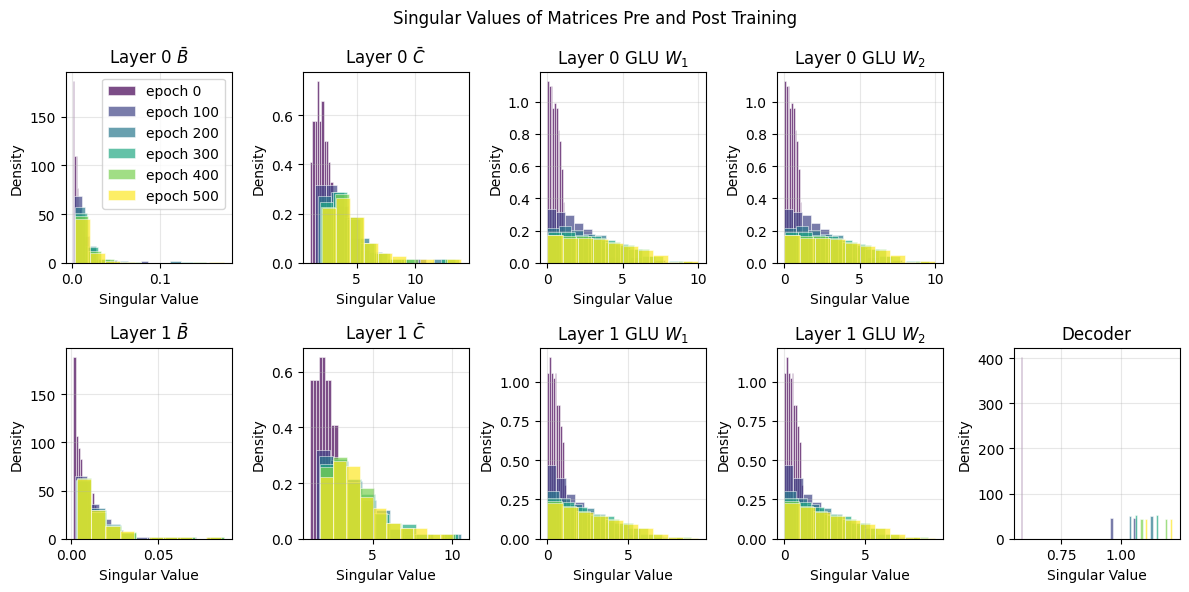

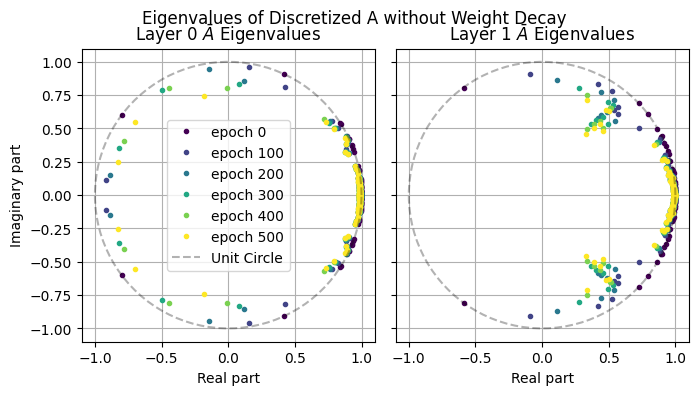

In [41]:
# discretized_parameters = {'fresh': {}, 'trained': {}}
model_cls = SSMFoundationalDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_pretrain/l2_reaching_normalized_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

plot_matrix_sv_pre_post_training(models) 
plot_A_matrix_pre_post_training(models)

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}}


wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': False, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinaji

wandb:   3 of 3 files downloaded.  


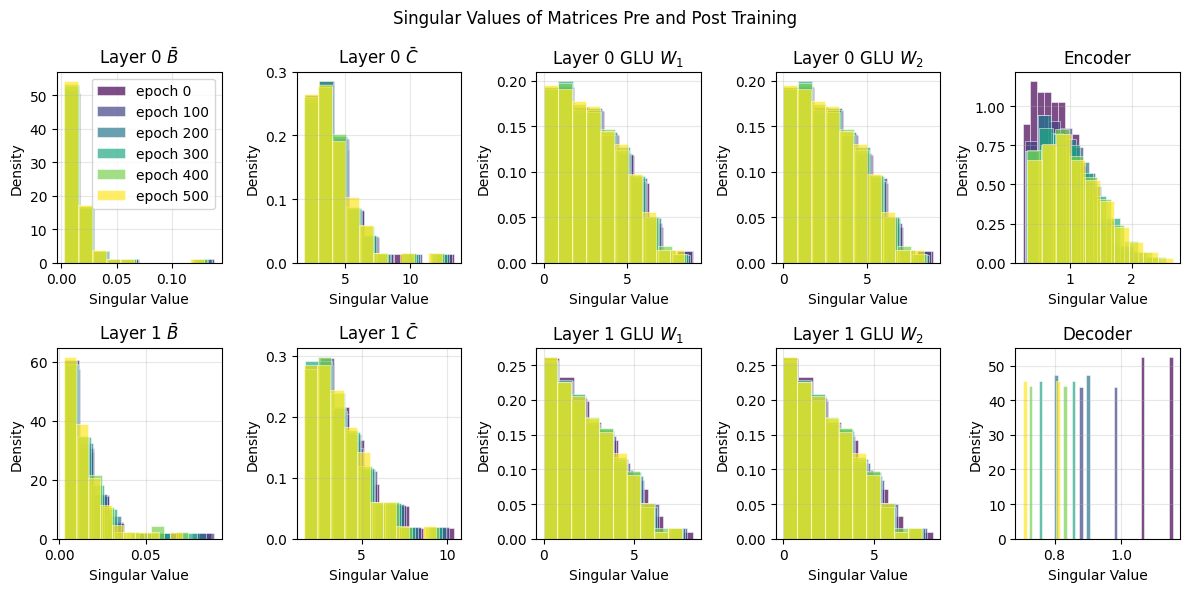

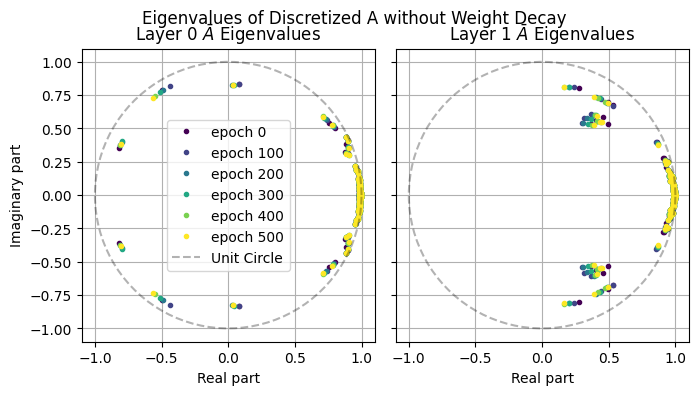

In [42]:
# discretized_parameters = {'fresh': {}, 'trained': {}}
model_cls = SSMDownstreamDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_rtt/l2_reaching_normalized_all_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

plot_matrix_sv_pre_post_training(models) 
plot_A_matrix_pre_post_training(models)

# Downstream, From Scratch

{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'training.from_scratch': True}

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


{'model': {'dt_max': 0.01, 'dt_min': 0.001, 'ssm_dim': 128, 'rng_seed': 42, 'dropout_p': 0.03, 'input_dim': 130, 'output_dim': 2, 'ssm_io_dim': 256, 'ssm_dropout_p': 0.01, 'ssm_num_layers': 2, 'ssm_init_diag_blocks': 4}, 'wandb': {'tags': ['neural', 'behavior', 'downstream', 'decoding', 'rtt'], 'entity': 'melinajingting-ucl', 'project': 'foundational_ssm_rtt'}, 'device': 'cuda', 'dataset': {'test': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_val.h5', 'phase': 'test', 'train': '/cs/student/projects1/ml/2024/mlaimon/data/foundational_ssm/processed/nlb/mc_rtt_trialized_train.h5', 'batch_size': 64, 'skip_timesteps': 56}, 'rng_seed': 42, 'training': {'epochs': 1001, 'from_scratch': True, 'log_val_every': 100, 'checkpoint_every': 100, 'save_activations': False, 'save_checkpoints': True, 'log_pred_and_activations_every': 999}, 'optimizer': {'lr': 0.002, 'mode': 'all', 'weight_decay': 0.01}, 'optimizer.mode': 'all', 'model.checkpoint': 'melinajin

wandb:   3 of 3 files downloaded.  


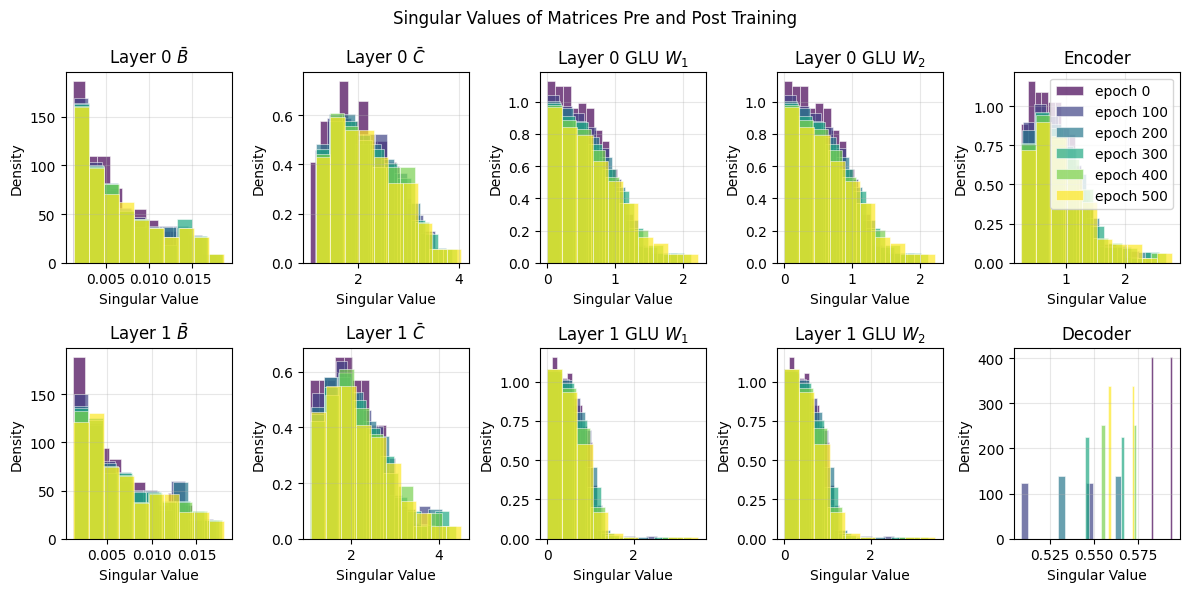

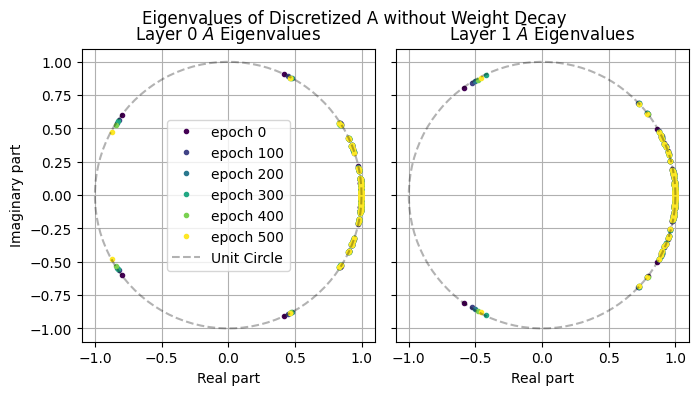

In [32]:
# discretized_parameters = {'fresh': {}, 'trained': {}}
model_cls = SSMDownstreamDecoder
checkpoint_name = 'melinajingting-ucl/foundational_ssm_rtt/l2_scratch_all_checkpoint'
models = {}
epochs = list(range(0,501,100))

for epoch in epochs:
    artifact_full_name = f'{checkpoint_name}:epoch_{epoch}'
    model, state, meta = load_model_and_state_from_checkpoint_wandb(artifact_full_name, model_cls=model_cls)
    models.update({
        f'epoch {epoch}':model
    })    

plot_matrix_sv_pre_post_training(models) 
plot_A_matrix_pre_post_training(models)